## Breast Cancer: Causes and Drug Target Prediction

The program analyzes the cause of breast cancer from a Boolean network datamodel, namely which genes should be mutated to cause cancer and are they oncogenes (True) or tumor suppressors (False).
Next, the program found the potential therapeutic targets and the actions on them for a cancer caused by BRCA1 mutation.

In [1]:
# BREAST CANCER CAUSES AND DRUG PREDICTION
import time
import matplotlib.pyplot as plt
from sympy import SOPform, simplify_logic
from tabulate import tabulate
from pulp import PULP_CBC_CMD
from boon import *

## Network model
import the network model from a text file. Note that this model also exists in BooN format.
Note that in a normal cell these two phenotypes exist potentially.
The model is a Boolean network connecting genes involved in Beast cancer.

In [2]:
#  Load the breast cancer network model (bcbn). A version of the model in BNet is also available 
bcbn = BooN.load("breast-cancer")

# Show the Boolean network
print(" - Boolean Network - ")
print(bcbn)

 - Boolean Network - 
MDM2 = Akt ∧ p53
CycD1 = (ERK12 ∧ ¬GSK3) ∨ (PARP1 ∧ ¬BRCA1)
PARP1 = ERK12
BRCA1 = ¬CycD1
PIK3CA = EGFR ∧ ¬PTEN
Bcl2 = Akt
EGFR = ¬BRCA1
p53 = (BRCA1 ∧ ¬MDM2) ∨ (¬MDM2 ∧ ¬PARP1)
ERK12 = EGFR
Bax = p53 ∧ ¬Bcl2
PTEN = p53
Akt = PIK3CA
GSK3 = ¬Akt


In [3]:
# print all the genes.
print("\n", "List of genes: ", bcbn.variables)


 List of genes:  {MDM2, CycD1, PARP1, BRCA1, PIK3CA, Bcl2, EGFR, p53, ERK12, Bax, PTEN, Akt, GSK3}


### Stable States
In this model two stable states exist that respectively correspond to cell division and apoptosis, identified by the Boolean version of the biomarker states. 

In [4]:
# Compute the stable states.
print("\n" * 2, " - Stable States -")
stable_states = bcbn.stable_states
print(tabulate(stable_states, headers='keys', tablefmt='plain'))



  - Stable States -
CycD1    PARP1    PIK3CA    PTEN    GSK3    Bax    EGFR    Akt    Bcl2    BRCA1    MDM2    p53    ERK12
False    False    False     True    True    True   False   False  False   True     False   True   False
True     True     True      False   False   False  True    True   True    False    False   False  True


### Interaction Graph

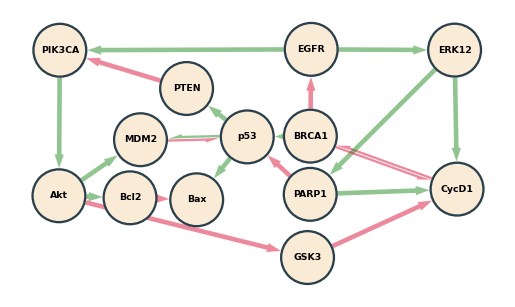

In [5]:
# interaction graph
bcbn.draw_IG()
plt.show()  # Show the interaction graph

## Cause of Cancer
Firstly, to ascertain the potential causes of cancer, a controllability analysis is  employed.
This analysis is based on the characterisation of biomarkers, which are genes whose states are used to differentiate between phenotypes.
These biomarkers are CycD1 and Bax
Based on the states of the aforementioned biomarkers, a control query is then defined with the objective of identifying the cause of cancer. 

### Characterization of the biomarkers
The selected biomarkers are CycD1 and Bax. The Boolean profiles, respectively, correspond to cell division and apoptosis.


| CyCD1 | Bax | *Phenotype* |
|:-----:|:-----:| -------:|
| 0 | 1 | *Apoptosis* |
| 1 | 0 | *Cell Division* |


In [6]:
# Define the biomarkers
CycD1, Bax = symbols("CycD1 Bax")
biomarkers = {CycD1, Bax}

In essence, the model represents the cancerous state as a loss of apoptosis, which is a hallmark of cancer.
We will define a query, or formula, that delineates the circumstances under which apoptosis cannot be sustained in any stable state. 

In [7]:
# Characterize a marking corresponding to the apoptosis
marking = {CycD1: False, Bax: True}
# convert the marking into a formula
apoptosis_marking = SOPform(biomarkers, [marking])
print("Apoptosis biomarkers")
print(tabulate([marking], headers='keys', tablefmt='plain'))

Apoptosis biomarkers
CycD1    Bax
False    True



### Control query definition
Set the marking formula of cancer loosing the apoptosis, that is the negation of apoptosis query, A cell therefore cannot die defining a hallmark of cancer.

In [8]:
 kquery = simplify_logic(~apoptosis_marking, force=True)
print("Disease query, prevent apoptosis: ", kquery)

Disease query, prevent apoptosis:  CycD1 | ~Bax


Now, we Define the variables where the control can be applied to force the freeze of variables.
A variable can have a two controls for freezing to True and to False.
Obviously, the biomarkers are always excluded from the control since they are observers characterizing the phenotypes by their profile. 

In [9]:
frozenvars0 = frozenvars1 = bcbn.variables - biomarkers
print("Frozen variables 0 and 1")
print(tabulate([frozenvars0, frozenvars1], tablefmt='grid'))

Frozen variables 0 and 1
+------+-------+-------+--------+------+------+-----+-------+------+-----+------+
| MDM2 | PARP1 | BRCA1 | PIK3CA | Bcl2 | EGFR | p53 | ERK12 | PTEN | Akt | GSK3 |
+------+-------+-------+--------+------+------+-----+-------+------+-----+------+
| MDM2 | PARP1 | BRCA1 | PIK3CA | Bcl2 | EGFR | p53 | ERK12 | PTEN | Akt | GSK3 |
+------+-------+-------+--------+------+------+-----+-------+------+-----+------+


Finally, we extend the Boolean network to a Boolean Controlled network according to the frozen variables. 

### Boolean Controlled Network (BCN)
Copy the network and fix the control on it. The control consists in adding control parameters such that: 
- _u0X: is the control for setting the variable X to False
- _u1X: is the control for setting the variable X to True.

A control is active when it freezes (set to 0/False). 


In [10]:
# BCN
bcc = bcbn.copy()
bcc.control(frozenvars0, frozenvars1)
print(bcc)

MDM2 = ¬_u1MDM2 ∨ (Akt ∧ _u0MDM2 ∧ p53)
CycD1 = (ERK12 ∧ ¬GSK3) ∨ (PARP1 ∧ ¬BRCA1)
PARP1 = ¬_u1PARP1 ∨ (ERK12 ∧ _u0PARP1)
BRCA1 = ¬_u1BRCA1 ∨ (_u0BRCA1 ∧ ¬CycD1)
PIK3CA = ¬_u1PIK3CA ∨ (EGFR ∧ _u0PIK3CA ∧ ¬PTEN)
Bcl2 = ¬_u1Bcl2 ∨ (Akt ∧ _u0Bcl2)
EGFR = ¬_u1EGFR ∨ (_u0EGFR ∧ ¬BRCA1)
p53 = ¬_u1p53 ∨ (_u0p53 ∧ ((BRCA1 ∧ ¬MDM2) ∨ (¬MDM2 ∧ ¬PARP1)))
ERK12 = ¬_u1ERK12 ∨ (EGFR ∧ _u0ERK12)
Bax = p53 ∧ ¬Bcl2
PTEN = ¬_u1PTEN ∨ (_u0PTEN ∧ p53)
Akt = ¬_u1Akt ∨ (PIK3CA ∧ _u0Akt)
GSK3 = ¬_u1GSK3 ∨ (_u0GSK3 ∧ ¬Akt)


 ### Controllability Analysis
A controllability analysis should be conducted for  identifying  the potential gene freezes that would satisfy the query at stable state. 

The number of models is approximately 3,500. We kindly request your patience.

In [11]:
print("\nQuery: Necessary avoid the apoptosis.")
start_time = time.time()
 # The trace is activated to see the evolution of the computation.
destiny = bcc.necessary(kquery, trace=True) 
print("Runtime..: {:5.2f}".format(time.time() - start_time))
print("# clauses: {}".format(len(destiny.args)))
print("# symbols: {}".format(destiny.count(Symbol)))


Query: Necessary avoid the apoptosis.
BooN CNF >> # SAT models:[ 3452]
BooN CNF >> CNF formatting: 100% |██████████████████[3452  - 00:25 - 137.84it/s]
Runtime..: 73.10
# clauses: 3452
# symbols: 53507


### Controllability Analysis

In [12]:
print("\nCore")
print("About 10 solutions.")
# Compute the core.
start_time = time.time()
# The  standard Pulp solver (Default) is used. However other solvers as GUROBI can be used for improving the performance of the resolution.
core = BooN.destify(destiny, trace=True, solver=PULP_CBC_CMD)
print("Runtime: {:5.2f}".format(time.time() - start_time))


Core
About 10 solutions.
BooN PI >> # solutions:[  9]                           
Runtime: 14.55


From the core, we derive the potential freeze actions as a pair (gene, freeze action).
The table comprises a series of lines, each corresponding to a specific freeze action on genes that is necessary to fulfil the query.
In the event that two pairs are present within a single line, it is necessary to combine the both actions. 

In [13]:
print("\nActions")  # Transform the core into actions.
actions = core2actions(core)
print(tabulate(actions))


Actions
--------------  -------------
(Akt, True)
(p53, False)
(Bcl2, True)
(BRCA1, False)
(PIK3CA, True)
(MDM2, True)
(GSK3, False)   (ERK12, True)
(PTEN, False)   (EGFR, True)
(GSK3, False)   (EGFR, True)
--------------  -------------


## Drug Target identification
We now identify the possible drug target associated with the expected action to cure BRCA1 Cancer.

In [14]:
# We define a situation of cancer with BRCA1 mutation.
print("\n" * 2, " - Mutate BRCA1  -")
BRCA1 = symbols("BRCA1")
bcbn.desc[BRCA1] = False

print("Mutated network.")
print(bcbn)



  - Mutate BRCA1  -
Mutated network.
MDM2 = Akt ∧ p53
CycD1 = (ERK12 ∧ ¬GSK3) ∨ (PARP1 ∧ ¬BRCA1)
PARP1 = ERK12
BRCA1 = false
PIK3CA = EGFR ∧ ¬PTEN
Bcl2 = Akt
EGFR = ¬BRCA1
p53 = (BRCA1 ∧ ¬MDM2) ∨ (¬MDM2 ∧ ¬PARP1)
ERK12 = EGFR
Bax = p53 ∧ ¬Bcl2
PTEN = p53
Akt = PIK3CA
GSK3 = ¬Akt


Define the frozen variables from the previous situation of the frozen variables by removing BRCA1

In [15]:
# copy the network and apply control
# Remove the mutated gene from the controlled variable since no modifications is possible.
frozenvars0 = frozenvars1 = frozenvars0 - {BRCA1}
bndrug = bcbn.copy()  # fix control on a new instance of bcbn.
bndrug.control(frozenvars0, frozenvars1)

### Controllability analysis
The issue is to identify the actions that induce apoptosis in order to determine the most effective therapeutic targets.
It is hypothesised that at least a stable state will fulfil the query property since the drug may not work for all people. 

Note that the possibility resolution is faster than the necessity.

In [16]:

print("\nQuery : Possibly lead to apoptosis.")
start_time = time.time()
destiny = bndrug.possibly(apoptosis_marking)
print("Runtime..: {:5.2f}".format(time.time() - start_time))
print("# clauses: {}".format(len(destiny.args)))
print("# symbols: {}".format(destiny.count(Symbol)))


Query : Possibly lead to apoptosis.
Runtime..:  0.01
# clauses: 15
# symbols: 56


In [17]:
print("\nCore")
start_time = time.time()
core = BooN.destify(destiny)
print("Runtime: {:5.2f}".format(time.time() - start_time))


Core
Runtime:  0.66


From the core, we finally derive the potential freeze actions as a pair (gene, freeze action) to gain the apoptosis.

In [18]:
print("\nActions")  # Transform the core into actions.
actions = core2actions(core)
print(tabulate(actions))


Actions
--------------
(EGFR, False)
(ERK12, False)
(PARP1, False)
--------------
